In [1]:
import matplotlib.pyplot as plt


In [ ]:
from ipywidgets import interact
import ipywidgets as widgets

import matplotlib.pyplot as plt
import scipy.io

# Load the .mat file
mat_data = scipy.io.loadmat('2dt_heart.mat')

# Extract the image data
imgs = mat_data['imgs']  # shape: (128, 128, 11, 375)

# Function to display the image based on sample and timeframe
def display_image(time_i, sample_i):
    plt.figure(figsize=(6, 6))
    plt.imshow(imgs[:, :, time_i, sample_i], cmap='gray')
    plt.title(f'Timeframe {time_i}, Sample {sample_i}')
    plt.axis('off')
    plt.show()

# Create sliders for slice and timeframe
timeframe_slider = widgets.IntSlider(min=0, max=imgs.shape[2]-1, step=1, value=0, description='Timeframe')
sample_slider = widgets.IntSlider(min=0, max=imgs.shape[3]-1, step=1, value=0, description='Sample')

# Use interact to link sliders with the display function
interact(display_image, time_i=timeframe_slider, sample_i=sample_slider)

interactive(children=(IntSlider(value=0, description='Timeframe', max=10), IntSlider(value=0, description='Sam…

<function __main__.display_image(time_i, sample_i)>

In [3]:
import torch
import torch.nn.functional as F

def vtv_loss(x):
    """
    Computes the Vectorial Total Variation (VTV) loss as described in Eq. (19) of the script.

    Args:
        x (torch.Tensor): A dynamic image sequence of shape (T, H, W),
                          where T is the number of frames, H is the height, and W is the width.

    Returns:
        torch.Tensor: The VTV loss value (scalar).
    """
    T, H, W = x.shape

    # Compute spatial gradients for each frame (along spatial axes)
    grad_x = x[:, :, 1:] - x[:, :, :-1]       # horizontal gradient (along width)
    grad_y = x[:, 1:, :] - x[:, :-1, :]       # vertical gradient (along height)

    # Pad to (T, H, W) for consistent size
    grad_x = F.pad(grad_x, (0, 1), mode='replicate')   # pad last column (W dimension)
    grad_y = F.pad(grad_y, (0, 0, 0, 1), mode='replicate')  # pad last row (H dimension)

    # Compute squared gradient magnitude across time (sum over T)
    squared_gradients = grad_x**2 + grad_y**2
    vtv_map = squared_gradients.sum(dim=0)  # sum over T, shape: (H, W)

    # Take sqrt and sum over spatial dimensions
    vtv = torch.sqrt(vtv_map + 1e-8).sum()

    return vtv


In [4]:

# We'll use one sample (e.g., first sample) and permute to (T, H, W)
sample_idx = 0
sample = imgs[:, :, :, sample_idx]  # shape: (128, 128, 11)
sample = torch.tensor(sample, dtype=torch.float32).permute(2, 0, 1)  # (11, 128, 128)

# Compute VTV loss
loss = vtv_loss(sample)
print("VTV Loss:", loss.item())


VTV Loss: 1406.206787109375


In [5]:
import numpy as np

def generate_undersampling_mask(shape, acceleration, center_fraction=0.1, sigma=10):
    """
    Generates a 3D undersampling mask with incoherent sampling across time and a Laplace-shaped density.

    Args:
        shape: (H, W, T) — dimensions of k-space data
        acceleration: desired acceleration factor (e.g., 4 or 6)
        center_fraction: fraction of central k-space to fully sample
        sigma: width parameter for Laplace-shaped density (controls decay)

    Returns:
        mask: numpy array of shape (H, W, T) with 0 (unsampled) or 1 (sampled)
    """
    H, W, T = shape
    mask = np.zeros((H, W, T), dtype=np.float32)

    # 1️⃣ Always sample the center of k-space
    center_size_h = int(H * center_fraction)
    center_size_w = int(W * center_fraction)
    ch_start, ch_end = H//2 - center_size_h//2, H//2 + center_size_h//2
    cw_start, cw_end = W//2 - center_size_w//2, W//2 + center_size_w//2

    mask[ch_start:ch_end, cw_start:cw_end, :] = 1  # fully sample center for all time frames

    # 2️⃣ Create Laplace-shaped density for outer k-space sampling
    ky = np.arange(H) - H//2
    kx = np.arange(W) - W//2
    ky_grid, kx_grid = np.meshgrid(ky, kx, indexing='ij')
    distance = np.sqrt(ky_grid**2 + kx_grid**2)

    laplace_density = np.exp(-distance / sigma)
    laplace_density[ch_start:ch_end, cw_start:cw_end] = 0  # exclude fully sampled center

    # Normalize to sum to 1
    laplace_density /= laplace_density.sum()

    num_samples = int(H * W / acceleration) - (center_size_h * center_size_w)

    for t in range(T):
        # Flatten the density and sample points according to the probability
        flat_density = laplace_density.flatten()
        sampled_indices = np.random.choice(H * W, num_samples, replace=False, p=flat_density)
        sampled_coords = np.unravel_index(sampled_indices, (H, W))
        mask[sampled_coords[0], sampled_coords[1], t] = 1

    return mask


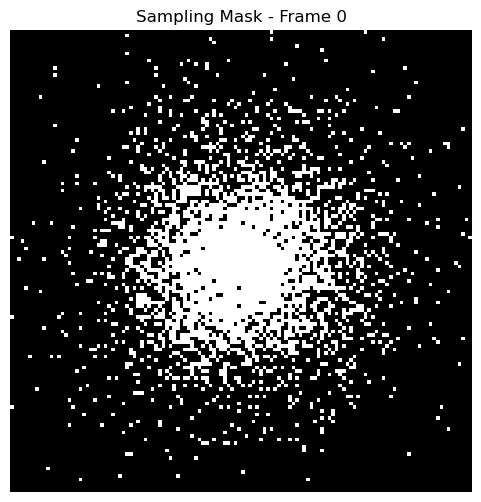

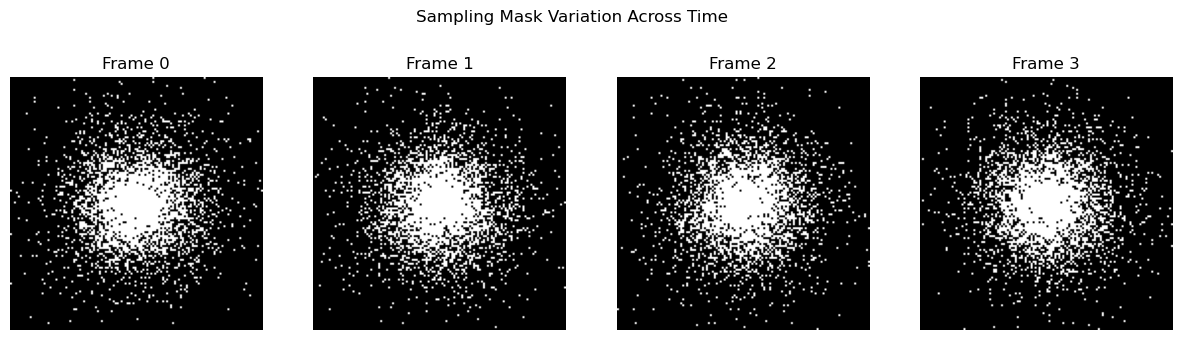

In [6]:
# Example shape and parameters
shape = (128, 128, 11)
acceleration = 6
center_fraction = 0.1
sigma = 10

# Generate the undersampling mask
mask = generate_undersampling_mask(shape, acceleration, center_fraction, sigma)

# Display a single frame of the mask (e.g., first temporal frame)
frame_idx = 0
plt.figure(figsize=(6, 6))
plt.imshow(mask[:, :, frame_idx], cmap='gray')
plt.title(f"Sampling Mask - Frame {frame_idx}")
plt.axis('off')
plt.show()

# If you want to see variation across time:
plt.figure(figsize=(15, 4))
for t in range(4):
    plt.subplot(1, 4, t+1)
    plt.imshow(mask[:, :, t], cmap='gray')
    plt.title(f'Frame {t}')
    plt.axis('off')
plt.suptitle('Sampling Mask Variation Across Time')
plt.show()


In [7]:
def compute_noisy_undersampled_measurements(img, mask, sigma=0.01):
    """
    Computes the noisy undersampled k-space measurements s = M (F x + N(0, sigma I)).

    Args:
        img (ndarray): Input image in spatial domain, shape (H, W, T)
        mask (ndarray): Binary undersampling mask, shape (H, W, T)
        sigma (float): Standard deviation of Gaussian noise

    Returns:
        s (ndarray): Noisy undersampled k-space data, shape (H, W, T)
    """
    # Compute Fourier transform of the image
    kspace_full = i2k(img, dims=(0, 1))  # apply FT along spatial dimensions only (H, W)

    # Add Gaussian noise (same shape as k-space)
    noise = np.random.normal(0, sigma, kspace_full.shape) + 1j * np.random.normal(0, sigma, kspace_full.shape)
    kspace_noisy = kspace_full + noise

    # Apply sampling mask (element-wise multiplication)
    s = mask * kspace_noisy

    return s


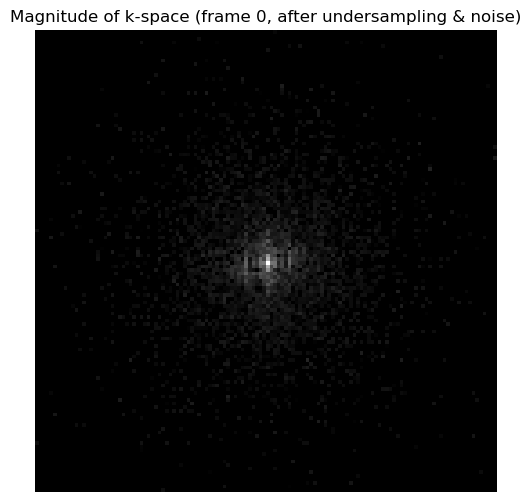

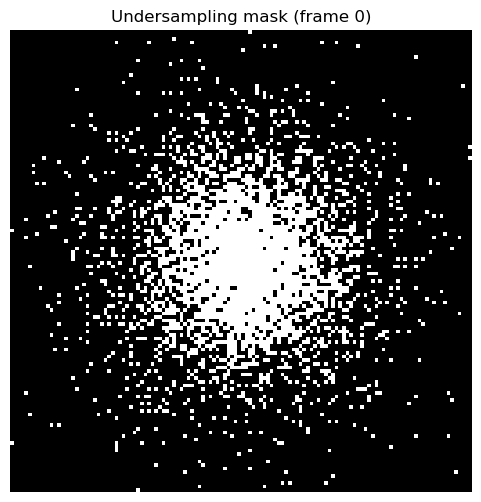

In [9]:
from utils import *

# Load the .mat file (if needed)
# mat_data = scipy.io.loadmat('2dt_heart.mat')
# imgs = mat_data['imgs']  # shape: (128, 128, 11, 375)
# sample = imgs[:, :, :, 0]  # example sample (H, W, T)

# Example sample 
H, W, T = 128, 128, 11
sample = imgs[:,:,:,0]

# Generate an example undersampling mask (Laplace density as before)
mask = generate_undersampling_mask(sample.shape, acceleration=6, center_fraction=0.1, sigma=10)

# Compute the undersampled noisy k-space measurements
s = compute_noisy_undersampled_measurements(sample, mask, sigma=0.1)

# Visualize the magnitude of the k-space (for first frame)
plt.figure(figsize=(6, 6))
plt.imshow(np.log1p(np.abs(s[:, :, 0])), cmap='gray')
plt.title('Magnitude of k-space (frame 0, after undersampling & noise)')
plt.axis('off')
plt.show()

# Visualize the mask for comparison
plt.figure(figsize=(6, 6))
plt.imshow(mask[:, :, 0], cmap='gray')
plt.title('Undersampling mask (frame 0)')
plt.axis('off')
plt.show()

